In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
import torch
import os
import PIL.Image as Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, f1_score
import time
from torch import optim,nn
from torchvision import models
from torch.autograd import Variable
from tqdm import *

from chestnet_utils import *

from IPython.display import FileLink

%load_ext autoreload
%autoreload 2

In [2]:
train_folder = 'data/train_/'
test_folder = 'data/test_/'
data_folder = 'data/'

## Data Exploration

In [3]:
random_subset = 10

In [115]:
files = !ls {train_folder}
files = np.array(files)
n = len(files)

(1024, 1024)


Text(0.5,1,'equalized')

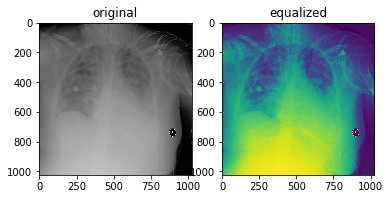

In [124]:
img = cv2.imread(f'{train_folder}{files[8]}',1)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
img2 = cv2.equalizeHist(img)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('equalized')

In [6]:
idx = np.random.choice(n,size=(random_subset,),replace=False)
for i, _ in enumerate(files[idx]):
    img = cv2.imread(f'{train_folder}{files[i]}',1)
    # all channels are same
    assert (np.logical_and( (img[:,:,0]==img[:,:,1]).all(), (img[:,:,1]==img[:,:,2]).all()) == True )

In [3]:
labels_tr = pd.read_csv(f'{data_folder}train.csv')
labels_tr.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [7]:
list(labels_tr.groupby('detected').count()['image_name'])

[436, 193, 786, 1623, 676, 535, 656, 5728, 1283, 2373, 1316, 2529, 377, 66]

In [8]:
labels_tr.isnull().values.any() #no null values

False

In [ ]:
labels_tr.groupby('detected').count()

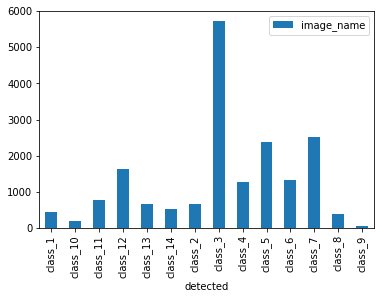

In [9]:
classes = pd.Series(['class_1','class_2', 'class_3', 'class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13','class_14',])
labels_tr.groupby('detected').count().reset_index().plot(kind='bar', x='detected',y='image_name')

In [10]:
rdc = labels_tr.groupby(['gender','detected']).count()
rdc

row_id   age  view_position  image_name
gender detected                                         
F      class_1      196   196            196         196
       class_10      74    74             74          74
       class_11     322   322            322         322
       class_12     702   702            702         702
       class_13     288   288            288         288
       class_14     200   200            200         200
       class_2      350   350            350         350
       class_3     2498  2498           2498        2498
       class_4      507   507            507         507
       class_5     1046  1046           1046        1046
       class_6      736   736            736         736
       class_7      978   978            978         978
       class_8      171   171            171         171
       class_9       43    43             43          43
M      class_1      240   240            240         240
       class_10     119   119            119         119
       class_11     464   464            464         464
       class_12     921   921            921         921
       class_13     388   388            388         388
       class_14     335   335            335         335
       class_2      306   306            306         306
       class_3     3230  3230           3230        3230
       class_4      776   776            776         776
       class_5     1327  1327           1327        1327
       class_6      580   580            580         580
       class_7     1551  1551           1551        1551
       class_8      206   206            206         206
       class_9       23    23             23          23

In [11]:
F = rdc.loc['F']
M = rdc.loc['M']
M

,row_id,age,view_position,image_name
detected,,,,
class_1,240,240,240,240
class_10,119,119,119,119
class_11,464,464,464,464
class_12,921,921,921,921
class_13,388,388,388,388
class_14,335,335,335,335
class_2,306,306,306,306
class_3,3230,3230,3230,3230
class_4,776,776,776,776


In [12]:
(M.index == F.index).any()

True

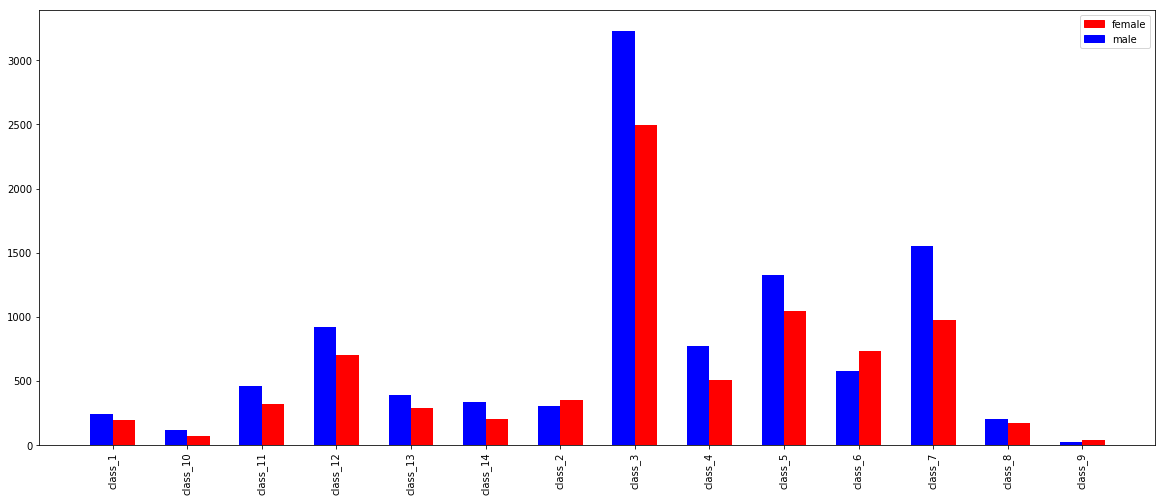

In [13]:
plt.figure(figsize = (20,8))
red_patch = mpatches.Patch(color='red', label='female')
blue_patch = mpatches.Patch(color='blue', label='male')
ax = plt.subplot(111)
plt.xticks(np.arange(len(classes)), M.reset_index()['detected'], rotation=90)
ax.bar(np.arange(len(classes)) - 0.3, M['age'],width=0.3,color='b',align='edge')
ax.bar(np.arange(len(classes)), F['age'],width=0.3,color='r',align='edge')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

In [14]:
files = labels_tr['image_name']
files[:10]

0        scan_0000.png
1        scan_0001.png
2       scan_00010.png
3     scan_0001000.png
4    scan_00010000.png
5    scan_00010001.png
6    scan_00010003.png
7    scan_00010004.png
8    scan_00010006.png
9    scan_00010007.png
Name: image_name, dtype: object

In [15]:
labels_tr.set_index('image_name').head()

,row_id,age,gender,view_position,detected
image_name,,,,,
scan_0000.png,id_0,45,M,0,class_3
scan_0001.png,id_1,57,F,0,class_3
scan_00010.png,id_10,58,M,0,class_3
scan_0001000.png,id_1000,64,M,0,class_6
scan_00010000.png,id_10000,33,M,1,class_3


In [17]:
classes_dict = dict(enumerate(labels_tr.detected.astype('category').cat.categories))
labels_tr['detected_id'] = labels_tr.detected.astype('category').cat.codes
classes_dict

{0: 'class_1',
 1: 'class_10',
 2: 'class_11',
 3: 'class_12',
 4: 'class_13',
 5: 'class_14',
 6: 'class_2',
 7: 'class_3',
 8: 'class_4',
 9: 'class_5',
 10: 'class_6',
 11: 'class_7',
 12: 'class_8',
 13: 'class_9'}

In [18]:
labels_tr.detected.astype('category').cat.codes

0         7
1         7
2         7
3        10
4         7
5        12
6        11
7        11
8         8
9         7
10        7
11        9
12        7
13       11
14        1
15        9
16       10
17       11
18       12
19        2
20        7
21        0
22        7
23        3
24        3
25       12
26        4
27        7
28       11
29        7
         ..
18547     8
18548    10
18549     7
18550     9
18551     7
18552     3
18553     5
18554     7
18555     9
18556     3
18557     7
18558     2
18559     3
18560     6
18561     7
18562     2
18563     8
18564     0
18565     7
18566     7
18567     8
18568     3
18569     7
18570    10
18571     7
18572     3
18573     7
18574     7
18575     7
18576    10
Length: 18577, dtype: int8

In [19]:
labels_tr.head()

,row_id,age,gender,view_position,image_name,detected,detected_id
0,id_0,45,M,0,scan_0000.png,class_3,7
1,id_1,57,F,0,scan_0001.png,class_3,7
2,id_10,58,M,0,scan_00010.png,class_3,7
3,id_1000,64,M,0,scan_0001000.png,class_6,10
4,id_10000,33,M,1,scan_00010000.png,class_3,7


In [20]:
labels_tr.detected.astype('category').cat.categories


Index(['class_1', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14',
       'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7',
       'class_8', 'class_9'],
      dtype='object')

In [21]:
compute_class_weight('balanced',np.arange(14),labels_tr.detected.astype('category').cat.codes)
# compute_class_weight('balanced',labels_tr.detected.unique(),labels_tr.detected)

array([  3.04341415,   6.87527757,   1.68820429,   0.81757768,
         1.96291209,   2.48024032,   2.02275697,   0.23165652,
         1.03423895,   0.55917765,   1.00830439,   0.52468508,
         3.51970443,  20.10497835])

## Data Loading and Transformations

0 (1024, 1024, 3) 7
1 (1024, 1024, 3) 7
2 (1024, 1024, 3) 7
3 (1024, 1024, 3) 10


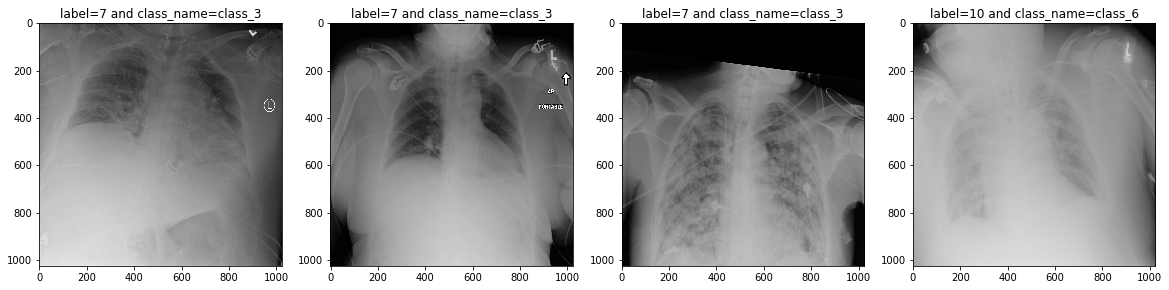

In [13]:
train_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',None)

fig = plt.figure(figsize=(20,5))


for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
    show_sample(sample['image'],sample['label'],train_dataset.idx_to_classes)

    if i == 3:
        plt.show()
        break
# del train_dataset

In [3]:
tfms = get_tfms(224)

transformed_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',transform=tfms)

use_gpu, num_workers = get_pm_for_dl()

samplers, dataloaders = get_dataloaders(transformed_dataset,16,num_workers,use_gpu)

<class 'numpy.ndarray'>


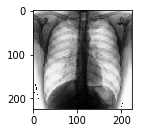

In [5]:
fig = plt.figure()
sample = transformed_dataset[65]
# transformed_sample = tsfrm(sample['image'])

ax = plt.subplot(1, 3, 1)
# plt.tight_layout()
# ax.set_title(type(tsfrm).__name__)
show_sample(Image.fromarray(np.uint8(sample['image']*255)))

plt.show()

In [33]:
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, sample_batched['image'].size(),sample_batched['label'].size())
    if i_batch==3:
        break

0 torch.Size([16, 3, 227, 227]) torch.Size([16])
1 torch.Size([16, 3, 227, 227]) torch.Size([16])
2 torch.Size([16, 3, 227, 227]) torch.Size([16])
3 torch.Size([16, 3, 227, 227]) torch.Size([16])


In [4]:
model_ft = models.resnet101(pretrained=True)
# for i,param in enumerate(model_ft.parameters()):
#     if i ==  5:
#         break
#     param.requires_grad = False
model_ft.fc = nn.Sequential(nn.Linear(2048, 14)) #after avgpool the size comes out to be features 2048

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001)

# # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
dataset_sizes = get_dt_szs(samplers)
dataset_sizes

{'sml_tr': 700, 'sml_val': 140, 'test': 3716, 'train': 11145, 'val': 3716}

In [6]:
model_ft.cuda()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4)
exp_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.7)
model_ft,b_acc,wts = train_model(model_ft, criterion, optimizer_ft, None,dataloaders,dataset_sizes,3,data_split=['train','sml_val'],save_model=True,name='resnet101')

Epoch 0/2
----------
if train
train Loss: 0.1282 Acc: 0.3458
else sml_val
sml_val Loss: 0.1290 Acc: 0.3500
setting best
Epoch 1/2
----------
if train
train Loss: 0.1182 Acc: 0.3946
else sml_val
sml_val Loss: 0.1355 Acc: 0.3357
Epoch 2/2
----------
if train
train Loss: 0.1126 Acc: 0.4213
else sml_val
sml_val Loss: 0.1303 Acc: 0.3714
setting best
Training complete in 27m 28s


In [88]:
torch.save(model_ft.state_dict(),'')

In [7]:
pdted,lbs = predict(model_ft,'sml_val',dataloaders,dataset_sizes,criterion)

sml_val
sml_val Loss: 0.1302 Acc: 0.3714


In [8]:
np.bincount(pdted)

array([ 0,  0,  0,  2,  0,  0,  8, 64,  1, 35,  8, 22])

In [9]:
np.bincount(lbs)

array([ 7,  0,  7, 10,  9,  2,  4, 32,  9, 33,  9, 15,  3])

In [128]:
f1_score(lbs,pdted,average='weighted')

/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.36658806264315319

In [31]:
new_model = models.resnet34(pretrained=True)
for i,param in enumerate(new_model.parameters()):
    if i ==  5:
        break
    param.requires_grad = False
new_model.fc = nn.Sequential(nn.Linear(2048,14))
new_model = change_to_cuda(new_model)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=0.0001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [50]:
new_model,tr_loss,val_loss = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

NameError: name 'new_model' is not defined

In [32]:
new_model.load_state_dict(torch.load('./models/model_0.3893972012917115'))  #45.8 is new_model resnet 34 without dropout

In [97]:
a,b = predict(new_model,'sml_val')

# f1_score(b,a,average='weighted')


sml_val Loss: 0.2795 Acc: 0.2786


In [98]:
np.bincount(b)

array([ 2,  3,  4, 13,  6,  2,  5, 39, 16, 13, 11, 23,  2,  1])

In [105]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=0.00001)
new_model,tr_loss,val_loss = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

Epoch 0/0
----------
train Loss: 0.0518 Acc: 0.7311
val Loss: 0.1371 Acc: 0.4150
Training complete in 5m 25s


In [19]:
dropout_model = models.resnet34(pretrained=True)
for i,param in enumerate(dropout_model.parameters()):
    if i ==  5:
        break
    param.requires_grad = False
dropout_model.fc = nn.Sequential(nn.Dropout(inplace=True),nn.Linear(2048,14))
dropout_model = change_to_cuda(dropout_model)

In [138]:
dropout_model.cuda()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, dropout_model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min',patience=1,verbose=True)
dropout_model,tr_loss,val_loss = lr_train_model(dropout_model, criterion, optimizer_ft, scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0973 Acc: 0.5015
val Loss: 0.1130 Acc: 0.4346
Epoch 1/9
----------
train Loss: 0.0925 Acc: 0.5257
val Loss: 0.1108 Acc: 0.4446
Epoch 2/9
----------
train Loss: 0.0878 Acc: 0.5515
val Loss: 0.1161 Acc: 0.4233
Epoch 3/9
----------
train Loss: 0.0839 Acc: 0.5682
Epoch     3: reducing learning rate of group 0 to 1.0000e-05.
val Loss: 0.1213 Acc: 0.4462
Epoch 4/9
----------
train Loss: 0.0687 Acc: 0.6444
val Loss: 0.1157 Acc: 0.4502
Epoch 5/9
----------
train Loss: 0.0617 Acc: 0.6803
Epoch     5: reducing learning rate of group 0 to 1.0000e-06.
val Loss: 0.1203 Acc: 0.4467
Epoch 6/9
----------
train Loss: 0.0579 Acc: 0.7020
val Loss: 0.1214 Acc: 0.4451
Epoch 7/9
----------
train Loss: 0.0562 Acc: 0.7093
Epoch     7: reducing learning rate of group 0 to 1.0000e-07.
val Loss: 0.1204 Acc: 0.4491
Epoch 8/9
----------
train Loss: 0.0558 Acc: 0.7113
val Loss: 0.1225 Acc: 0.4446
Epoch 9/9
----------
train Loss: 0.0563 Acc: 0.7108
Epoch     9: reducing learning ra

In [101]:
dropout_model.load_state_dict(torch.load('./models/model_0.4502152852529602'))
pdted,lb = predict(dropout_model,'sml_val')

sml_val Loss: 0.1235 Acc: 0.4429


In [102]:
f1_score(lb,pdted,average='weighted')

/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.42634803997953996

In [103]:
np.bincount(pdted)

array([ 4,  0,  2,  9,  9,  2,  1, 54, 11, 19,  8, 20,  1])

In [105]:
f1_score(lb,pdted,average='micro')

0.44285714285714284

In [20]:
tfms = get_tfms(224)
transformed_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',transform=tfms,subset=700)
samplers, dataloaders = get_dataloaders(transformed_dataset,16,1,use_gpu)
datasert_sizes = get_dt_szs(samplers)

In [21]:
model_resnet50 = models.resnet50(pretrained=True)
for i,param in enumerate(model_resnet50.parameters()):
    if i ==  5:
        break
    param.requires_grad = False
model_resnet50.fc = nn.Sequential(nn.Dropout(inplace=True),nn.Linear(2048,14))
model_resnet50 = change_to_cuda(model_resnet50)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min',patience=1,verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.4)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(transformed_dataset.class_weights).cuda())

In [124]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_resnet50.parameters()), lr=1e-5)
model_resnet50,_,_ = train_model(model_resnet50, criterion, optimizer_ft, scheduler, 6, ['sml_trn','sml_val'], 'fianlresnet50_', save_model=True)

NameError: name 'train_model' is not defined

In [30]:
pdted,lbs = predict(model_resnet50,'sml_val')

sml_val Loss: 0.2254 Acc: 0.2143


In [37]:
np.bincount(pdted)

array([  86,    0,   52,  221,  127,  101,  115, 1450,  239,  553,  237,
        486,   47,    2])

In [38]:
np.bincount(lbs)

array([  90,   39,  142,  364,  130,  118,  136, 1108,  288,  471,  247,
        492,   76,   15])

In [22]:
model_resnet50.load_state_dict(torch.load('./models/model_fianlresnet50__0.32292787944025836'))

In [24]:
pdted,lbs = predict(model_resnet50,'sml_val')

sml_val Loss: 0.1246 Acc: 0.3143


In [35]:
f1_score(lbs,pdted,average='weighted')

/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4223097278347604

In [ ]:

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

model = nn.Sequential(nn.BatchNorm2d(3),
                      
                     )

In [21]:
dropout_model.load_state_dict(torch.load('./models/model_0.4502152852529602'))


In [124]:
tfms = get_tfms(224)
transformed_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',transform=tfms,subset=700)
samplers, dataloaders = get_dataloaders(transformed_dataset,16,1,use_gpu)
datasert_sizes = get_dt_szs(samplers)

In [106]:
dataloaders

{'sml_tr': <torch.utils.data.dataloader.DataLoader at 0x7f7cb6a70668>,
 'sml_val': <torch.utils.data.dataloader.DataLoader at 0x7f7cb6a706d8>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f7cb6a705f8>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f7cb6a70518>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f7cb6a70588>}

In [107]:
pdted,lbs = predict(dropout_model,'val')

TypeError: predict() missing 2 required positional arguments: 'dataloaders' and 'dataset_sizes'

In [36]:
pdted,lbs = predict(dropout_model,'test')


test Loss: 0.1692 Acc: 0.4413


## Using Outer models

In [167]:
tfms = get_tfms(224)
transformed_dataset = XRayDataset(f'{data_folder}train.csv',f'{data_folder}',transform=tfms,subset=500)
samplers, dataloaders = get_dataloaders(transformed_dataset,16,1,use_gpu)
dataset_sizes = get_dt_szs(samplers)

In [187]:
dense121 = models.resnet34(pretrained=True)
num_features = dense121.fc.in_features
dense121.fc = nn.Sequential(nn.Linear(num_features, 14))
dense121.cuda()
for i,param in enumerate(dense121.parameters()):
    if i ==  5:
        break
    param.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min',patience=1,verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.5)

In [186]:
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft,gamma=0.7)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.5)

In [189]:
dense121,_,_ = train_model(dense121,criterion,optimizer_ft,scheduler,3,['train','sml_val'],'tempdensenet121',False)

Epoch 0/2
----------
iftrain
train Loss: 0.1689 Acc: 0.0749
else   sml_val
sml_val Loss: 0.1881 Acc: 0.0900
Epoch 1/2
----------
iftrain


Process Process-446:
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/src/anaconda3/envs/my_root/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-3-07bab54eaa16>", line 31, in __getitem__
    img = cv2.imread(img_path,1)


In [ ]:
pdted,lbs = predict(dense121,'sml_val',dataloaders,dataset_sizes)

In [121]:
np.bincount(pdted)

array([  2,   5,   1,   1,   2,   2,  11, 110,   5,   1])

In [122]:
np.bincount(lbs)

array([ 4,  1,  6, 14,  5,  1,  5, 52, 11, 15,  6, 18,  2])

In [158]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min',patience=1,verbose=True)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft,gamma=0.5)



class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

model = nn.Sequential(nn.BatchNorm2d(3),
                      Flatten(),
                      nn.Conv2d(3,32,3),
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      nn.AvgPool2d(2),
                      nn.Conv2d(32,64,3),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      nn.AvgPool2d(2),
                      Flatten(),
                      nn.Linear(200,14)
                    ).cuda()


model,_,_ = lr_train_model(model,criterion,optimizer_ft,scheduler,2,['sml_tr','sml_val'],'tempdensenet121',False)

Epoch 0/1
----------


ValueError: Expected 4D tensor as input, got 2D tensor instead.

In [113]:
get_subm_link(model_ft,criterion,tfms,transformed_dataset)

test
test Loss: 0.1560 Acc: 0.0012


/home/ubuntu/my_project/chestnet/sdir/fst.csv